In [1]:
#import libraries
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import cv2

In [2]:

#dataloading
train_dir = "../input/uw-madison-gi-tract-image-segmentation/train"
training_metadata_path = "../input/uw-madison-gi-tract-image-segmentation/train.csv"

train_df = pd.read_csv(training_metadata_path)
display(train_df.head())
display(train_df.info())


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


None

In [3]:
train_df['case_id'] = train_df['id'].apply(lambda x: x.split('_')[0][4:])
train_df['day_id'] = train_df['id'].apply(lambda x: x.split('_')[1][3:])
train_df['slice_id'] = train_df['id'].apply(lambda x: x.split('_')[-1])
# train_df["segmentation"] = train_df["segmentation"].astype("str")
display(train_df.head())

,id,class,segmentation,case_id,day_id,slice_id
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001
2,case123_day20_slice_0001,stomach,NaN,123,20,0001
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002


In [4]:
#from other notebook
def fetch_file_from_id(root_dir, case_id):
    case_folder = case_id.split("_")[0]
    day_folder = "_".join(case_id.split("_")[:2])
    file_starter = "_".join(case_id.split("_")[2:])
    # fetching folder paths
    folder = os.path.join(root_dir, case_folder, day_folder, "scans")
    # fetching filenames with similar pattern
    file = glob(f"{folder}/{file_starter}*")
    # returning the first file, though it will always hold one file.
    return file[0]
train_df["path"] = train_df["id"].apply(lambda x: fetch_file_from_id(train_dir, x))
train_df.head()

,id,class,segmentation,case_id,day_id,slice_id,path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...


In [5]:
display(train_df['path'][0])

'../input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png'

In [6]:
train_df['height'] = train_df['path'].apply(lambda x: os.path.split(x)[-1].split('_')[2])
train_df['width'] = train_df['path'].apply(lambda x: os.path.split(x)[-1].split('_')[3])
train_df['height_mask'] = train_df['path'].apply(lambda x: os.path.split(x)[-1].split('_')[4])
train_df['width_mask'] = train_df['path'].apply(lambda x: os.path.split(x)[-1].split('_')[5][0:4])
display(train_df.head())

,id,class,segmentation,case_id,day_id,slice_id,path,height,width,height_mask,width_mask
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50


In [7]:
Counter(train_df['class'])

Counter({'large_bowel': 38496, 'small_bowel': 38496, 'stomach': 38496})

In [8]:
class_names = train_df['class'].unique()
print(class_names)
for index, label in enumerate(class_names):
    train_df['class'].replace(label, index, inplace = True)
display(train_df.head())

['large_bowel' 'small_bowel' 'stomach']


,id,class,segmentation,case_id,day_id,slice_id,path,height,width,height_mask,width_mask
0,case123_day20_slice_0001,0,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
1,case123_day20_slice_0001,1,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
2,case123_day20_slice_0001,2,NaN,123,20,0001,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
3,case123_day20_slice_0002,0,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
4,case123_day20_slice_0002,1,NaN,123,20,0002,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50


In [9]:
#other visualising and analyzing data

In [10]:
#from other notebook

def prepare_mask_data(string):
    # fetching all the values from the string
    all_values = map(int, string.split(" "))
    # preparing the usable arrays
    starterIndex, pixelCount = [], []
    for index, value in enumerate(all_values):
        if index % 2:
            # storing even indexed values in pixelCount
            pixelCount.append(value)
        else:
            # storing odd indexed values in starterIndex
            starterIndex.append(value)
    return starterIndex, pixelCount
    
def fetch_pos_pixel_indexes(indexes, counts):
    final_arr = []
    for index, counts in zip(indexes, counts):
        # adding all the values from starterIndex to range of positive pixel counts
        final_arr += [index + i for i in range(counts)]
    return final_arr

def prepare_mask(string, height, width, color = 1):
    # preparing the respective arrays
    indexes, counts = prepare_mask_data(string)
    # preparing all the pixel indexes those have mask values
    pos_pixel_indexes = fetch_pos_pixel_indexes(indexes, counts)
    # forming the flattened array
    mask_array = np.zeros(height * width)
    # updating values in the array
    mask_array[pos_pixel_indexes] = color
    # reshaping the masks
    return mask_array.reshape(height, width)





In [11]:


segmentation_data = train_df[~train_df["segmentation"].isna()]
segmentation_case_id = segmentation_data["case_id"].unique()

case_id = random.choice(segmentation_data["case_id"].unique())

case_analyzed = segmentation_data[segmentation_data["case_id"] == case_id]

day_selected = random.choice(case_analyzed.day_id.unique())

day_analyzed  = case_analyzed[case_analyzed["day_id"] == day_selected] 



In [12]:
train_df[~train_df["segmentation"].isna()].head(1)

,id,class,segmentation,case_id,day_id,slice_id,path,height,width,height_mask,width_mask
194,case123_day20_slice_0065,2,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,0065,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50


In [13]:


stomach_analyzed = day_analyzed[day_analyzed["class"] == 2].sort_values("slice_id")



In [14]:
stomach_analyzed

,id,class,segmentation,case_id,day_id,slice_id,path,height,width,height_mask,width_mask
35909,case113_day0_slice_0050,2,49190 3 49547 8 49905 11 50264 12 50623 13 509...,113,0,0050,../input/uw-madison-gi-tract-image-segmentatio...,360,310,1.50,1.50
35912,case113_day0_slice_0051,2,50628 11 50986 14 51343 18 51701 20 52057 24 5...,113,0,0051,../input/uw-madison-gi-tract-image-segmentatio...,360,310,1.50,1.50
35915,case113_day0_slice_0052,2,47747 7 48106 9 48464 12 48822 15 49180 18 495...,113,0,0052,../input/uw-madison-gi-tract-image-segmentatio...,360,310,1.50,1.50
35918,case113_day0_slice_0053,2,44865 2 45223 6 45582 7 45942 9 46301 11 46660...,113,0,0053,../input/uw-madison-gi-tract-image-segmentatio...,360,310,1.50,1.50
35921,case113_day0_slice_0054,2,34059 4 34418 6 34777 8 35137 8 35497 8 35857 ...,113,0,0054,../input/uw-madison-gi-tract-image-segmentatio...,360,310,1.50,1.50
35924,case113_day0_slice_0055,2,32257 3 32615 6 32974 8 33334 9 33694 9 34054 ...,113,0,0055,../input/uw-madison-gi-tract-image-segmentatio...,360,310,1.50,1.50
35927,case113_day0_slice_0056,2,30812 9 31171 11 31531 12 31890 14 32250 15 32...,113,0,0056,../input/uw-madison-gi-tract-image-segmentatio...,360,310,1.50,1.50
35930,case113_day0_slice_0057,2,30094 6 30453 8 30812 10 31171 12 31531 12 318...,113,0,0057,../input/uw-madison-gi-tract-image-segmentatio...,360,310,1.50,1.50
35933,case113_day0_slice_0058,2,29374 2 29732 6 30091 10 30450 12 30810 13 311...,113,0,0058,../input/uw-madison-gi-tract-image-segmentatio...,360,310,1.50,1.50
35936,case113_day0_slice_0059,2,29372 7 29731 9 30090 11 30450 11 30810 12 311...,113,0,0059,../input/uw-madison-gi-tract-image-segmentatio...,360,310,1.50,1.50


In [15]:
mask_array = []

for index, row in stomach_analyzed.iterrows():    
    mask = prepare_mask(row["segmentation"], int(row["height"]), (int(row["width"])))
    mask_array.append(mask)

In [16]:
def view_images(images, nb_elements = 5):
    nb_samples = len(images)
    print(nb_samples)
    nb_rows = ((nb_samples) // 5) + 1
    
    fig, axes = plt.subplots(
        nrows = nb_rows, 
        ncols = min(5, nb_samples), 
        figsize = (min(5, nb_samples) * 4, nb_rows * 4)
    )
    
    for i in range(nb_samples):    
        img = images[i]
        axes[i // 5, i % 5].imshow(np.array(img), cmap=plt.cm.gray, aspect='auto')
        axes[i // 5, i % 5].axis('off')
    
    fig.show()    

In [17]:

# view_images([Image.fromarray(mask * 255) for mask in mask_array])

In [18]:
mask_array[0].shape

(360, 310)

In [19]:
DEMO_ID = "case123_day20_slice_0082"
demo_ex = train_df[train_df.id==DEMO_ID].squeeze()
demo_ex

,id,class,segmentation,case_id,day_id,slice_id,path,height,width,height_mask,width_mask
243,case123_day20_slice_0082,0,17481 4 17746 7 18010 10 18275 12 18539 14 188...,123,20,0082,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
244,case123_day20_slice_0082,1,22236 2 22500 6 22765 8 23030 10 23296 10 2356...,123,20,0082,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50
245,case123_day20_slice_0082,2,11052 8 11314 15 11578 19 11843 23 12108 26 12...,123,20,0082,../input/uw-madison-gi-tract-image-segmentatio...,266,266,1.50,1.50


In [20]:
def open_gray16(_path, normalize=True, to_rgb=False):
    """ Helper to open files """
    if normalize:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535., axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)/65535.
    else:
        if to_rgb:
            return np.tile(np.expand_dims(cv2.imread(_path, cv2.IMREAD_ANYDEPTH), axis=-1), 3)
        else:
            return cv2.imread(_path, cv2.IMREAD_ANYDEPTH)

In [21]:
path = demo_ex.iloc[0].path
path_str = str(path)
path_str

'../input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0082_266_266_1.50_1.50.png'

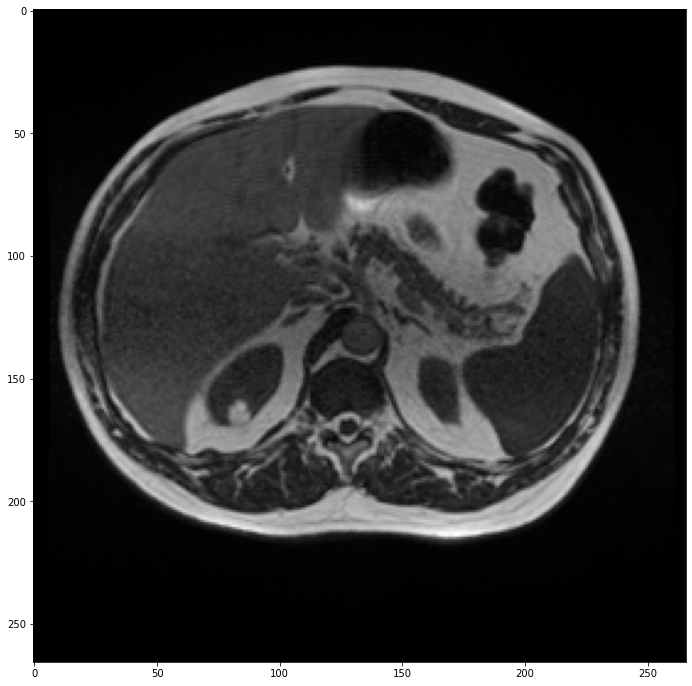

In [22]:

plt.figure(figsize = (12,12))
plt.imshow(open_gray16(path_str), cmap="gray")
plt.show()

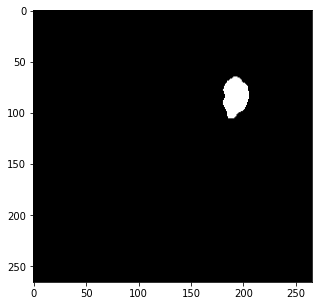

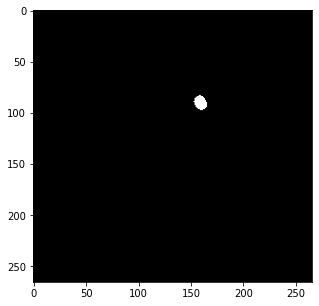

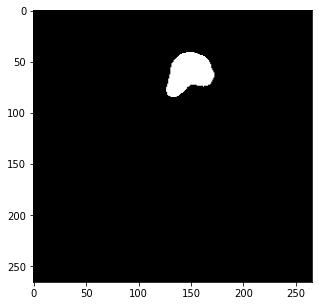

In [23]:
arr = []
for index, row in demo_ex.iterrows():
    m = prepare_mask(row["segmentation"], int(row["height"]), (int(row["width"])), color = 3)
    arr.append(m)
for m in arr:
    plt.figure(figsize = (5,5))
    plt.imshow(np.array(m * 255), cmap=plt.cm.gray, aspect='auto')
    plt.show()

In [24]:
st = np.stack(arr,axis = 2)
st.shape

(266, 266, 3)

In [25]:
image = open_gray16(path_str, to_rgb = True)
image = ((image-image.min())/(image.max()-image.min())).astype(np.float32) # normalize
image.shape

(266, 266, 3)

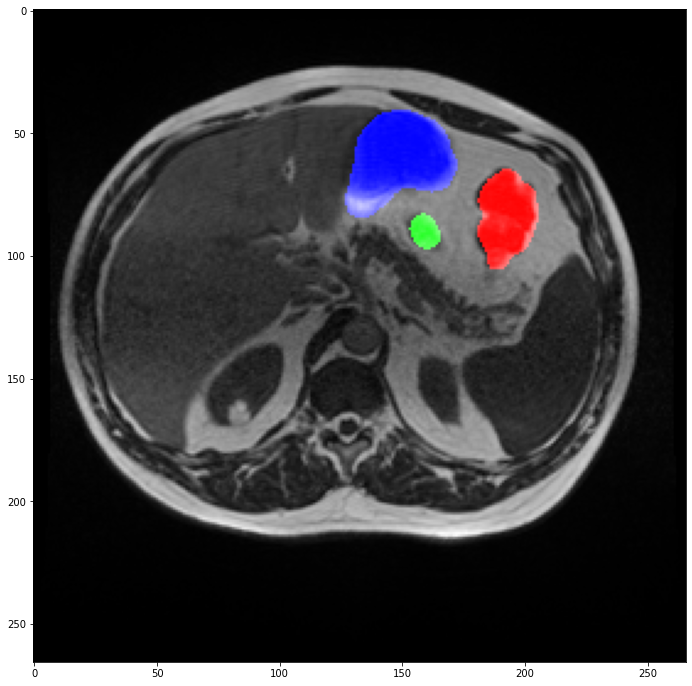

In [26]:
#now we want to
image = open_gray16(path_str, to_rgb = True)
image = ((image-image.min())/(image.max()-image.min())).astype(np.float32) # normalize
seg_overlay = cv2.addWeighted(src1=image, alpha=0.99, 
                              src2=np.stack(arr,axis = 2), beta=0.33, gamma=0.0,dtype=cv2.CV_64F)
plt.figure(figsize=(12,12))
plt.imshow(seg_overlay)

In [27]:
num_cases = len(train_df.path.unique())
one_anot = len({k for k, v in (Counter(segmentation_data.path)).items() if v==1})
two_anot = len({k for k, v in (Counter(segmentation_data.path)).items() if v==2})
three_anot = len({k for k, v in (Counter(segmentation_data.path)).items() if v==3})
print(f'for {num_cases} number of cases, {one_anot} cases have one annotation, {two_anot} cases have two annotations, {three_anot} cases have three annotations')


for 38496 number of cases, 2468 cases have one annotation, 10921 cases have two annotations, 3201 cases have three annotations


In [28]:
#most stomach out of 1 annotation
set_a = {k for k, v in (Counter(segmentation_data.path)).items() if v==1}
df = segmentation_data
df['path'] = segmentation_data['path'].apply(lambda x: x if x in set_a else np.nan)
df = df.dropna()
Counter(df['class'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Counter({2: 2286, 0: 123, 1: 59})